In [ ]:
import nltk
import random
import re
import string
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import twitter_samples, stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Download nltk resources
nltk.download("twitter_samples")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Dataset exploration

In [ ]:
pos_tweets = twitter_samples.strings("positive_tweets.json")
neg_tweets = twitter_samples.strings("negative_tweets.json")
type(pos_tweets), type(neg_tweets), len(pos_tweets), len(neg_tweets)

(list, list, 5000, 5000)

In [ ]:
# Split train/test datasets
train_pos, train_neg = pos_tweets[:4000], neg_tweets[:4000]
test_pos, test_neg = pos_tweets[4000:], neg_tweets[4000:]
train_tweets = train_pos + train_neg 
test_tweets = test_pos + test_neg
len(train_tweets), len(test_tweets)

(8000, 2000)

In [ ]:
# Create sentiment labels
#Y_train = np.append(np.ones((len(train_pos))), np.zeros((len(train_neg))))
#Y_test = np.append(np.ones((len(test_pos))), np.zeros((len(test_neg))))
#len(Y_train), len(Y_test)
Y_train = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
Y_test = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)
Y_train.shape, Y_test.shape

((8000, 1), (2000, 1))

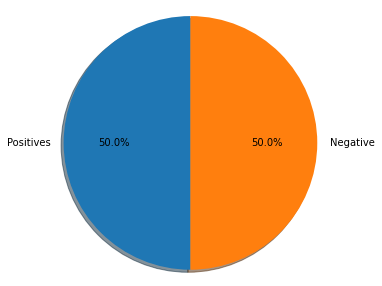

In [ ]:
# Declare a figure with a custom size
fig = plt.figure(figsize=(5, 5))

# labels for the two classes
labels = 'Positives', 'Negative'

# Sizes for each slide
sizes = [len(pos_tweets), len(neg_tweets)] 

# Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Display the chart
plt.show()

In [ ]:
# print positive in greeen
print('\033[92m' + pos_tweets[random.randint(0,5000)])

# print negative in red
print('\033[91m' + neg_tweets[random.randint(0,5000)])

@bunbun78 great shot - safe trip back to HK - love that place :-)
Ive been trying to play the damn beta for like 12 hours now :(


# Data preprocessing

In [ ]:
def process_tweet(tweet):
    """
    Clean and tokenize a tweet

    """
    # Regex cleaning  
    tweet2 = re.sub(r"https?:\/\/\S*", "", tweet)   # Remove hashtags and hyperlinks
    tweet3 = re.sub(r"#", "", tweet2)               # Remove hash signs

    # Tweets tokenization
    tokenizer = TweetTokenizer(preserve_case=False, 
                            strip_handles=True,     # Remove username handles
                            reduce_len=True)        # Replace repeated character sequences of length 3 or greater with sequences of length 3
    tweet_tokens = tokenizer.tokenize(tweet3)

    # Remove stop words and punctuation, and lemmatize
    stopwords_eng = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tweet_clean = [lemmatizer.lemmatize(token) for token in tweet_tokens if token not in stopwords_eng and token not in string.punctuation]

    return tweet_clean

In [ ]:
for tweet in train_tweets[:10]:
    print(tweet)
    print(process_tweet(tweet))
    print()

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
['followfriday', 'top', 'engaged', 'member', 'community', 'week', ':)']

@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
['hey', 'james', 'odd', ':/', 'please', 'call', 'contact', 'centre', '02392441234', 'able', 'assist', ':)', 'many', 'thanks']

@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
['listen', 'last', 'night', ':)', 'bleed', 'amazing', 'track', 'scotland']

@97sides CONGRATS :)
['congrats', ':)']

yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days
['yeaaah', 'yipppy', 'accnt', 'verified', 'rqst', 'succeed', 'got', 'blue', 'tick', 'mark', 'fb', 'profile', ':)', '15', 'day']

@BhaktisBanter @PallaviRuhail This one is irresistible :)
#FlipkartFashionFriday http://t.co/EbZ0L2V

# Feature extraction

In [ ]:
# Create frequencies dictionary
def create_word_freqs_dict(tweets, labels):
    tweets = [process_tweet(tweet) for tweet in tweets]
    word_freqs = {}
    for tweet, label in zip(tweets, labels):
        for word in tweet:
            if not (word, label[0]) in word_freqs:
                word_freqs[(word, label[0])] = 0
            word_freqs[(word, label[0])] += 1
    # return dictionary sorted by values 
    return dict(sorted(word_freqs.items(), key=lambda x:x[1], reverse=True))

In [ ]:
vocab_dict = create_word_freqs_dict(train_tweets, Y_train)
vocab_dict

{(':(', 0.0): 3675,
 (':)', 1.0): 2960,
 (':-)', 1.0): 552,
 (':D', 1.0): 523,
 (':-(', 0.0): 386,
 ('thanks', 1.0): 330,
 ('u', 1.0): 300,
 ('...', 0.0): 283,
 ('love', 1.0): 276,
 ('follow', 1.0): 274,
 ("i'm", 0.0): 266,
 ('please', 0.0): 242,
 ('...', 1.0): 228,
 ('♛', 0.0): 210,
 ('》', 0.0): 210,
 ('miss', 0.0): 198,
 ('thank', 1.0): 192,
 ('good', 1.0): 189,
 ('day', 1.0): 187,
 ('u', 0.0): 186,
 ('like', 1.0): 180,
 ('like', 0.0): 173,
 ('want', 0.0): 167,
 ('hi', 1.0): 154,
 ('happy', 1.0): 150,
 ('get', 0.0): 148,
 ("can't", 0.0): 148,
 ('see', 1.0): 143,
 ('get', 1.0): 142,
 ("i'm", 1.0): 140,
 ('back', 1.0): 138,
 ('great', 1.0): 135,
 ('follow', 0.0): 127,
 ('know', 1.0): 125,
 ('time', 0.0): 123,
 ('<3', 1.0): 119,
 ('sorry', 0.0): 118,
 ('love', 0.0): 118,
 ('one', 0.0): 118,
 ('much', 0.0): 116,
 ('day', 0.0): 115,
 ('new', 1.0): 114,
 ('go', 0.0): 114,
 ('know', 0.0): 110,
 ('followed', 0.0): 110,
 ('im', 0.0): 108,
 ('really', 0.0): 105,
 (':p', 1.0): 104,
 ('still', 0

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12299 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12299 missing from current font.
  font.set_text(s, 0, flags=flags)


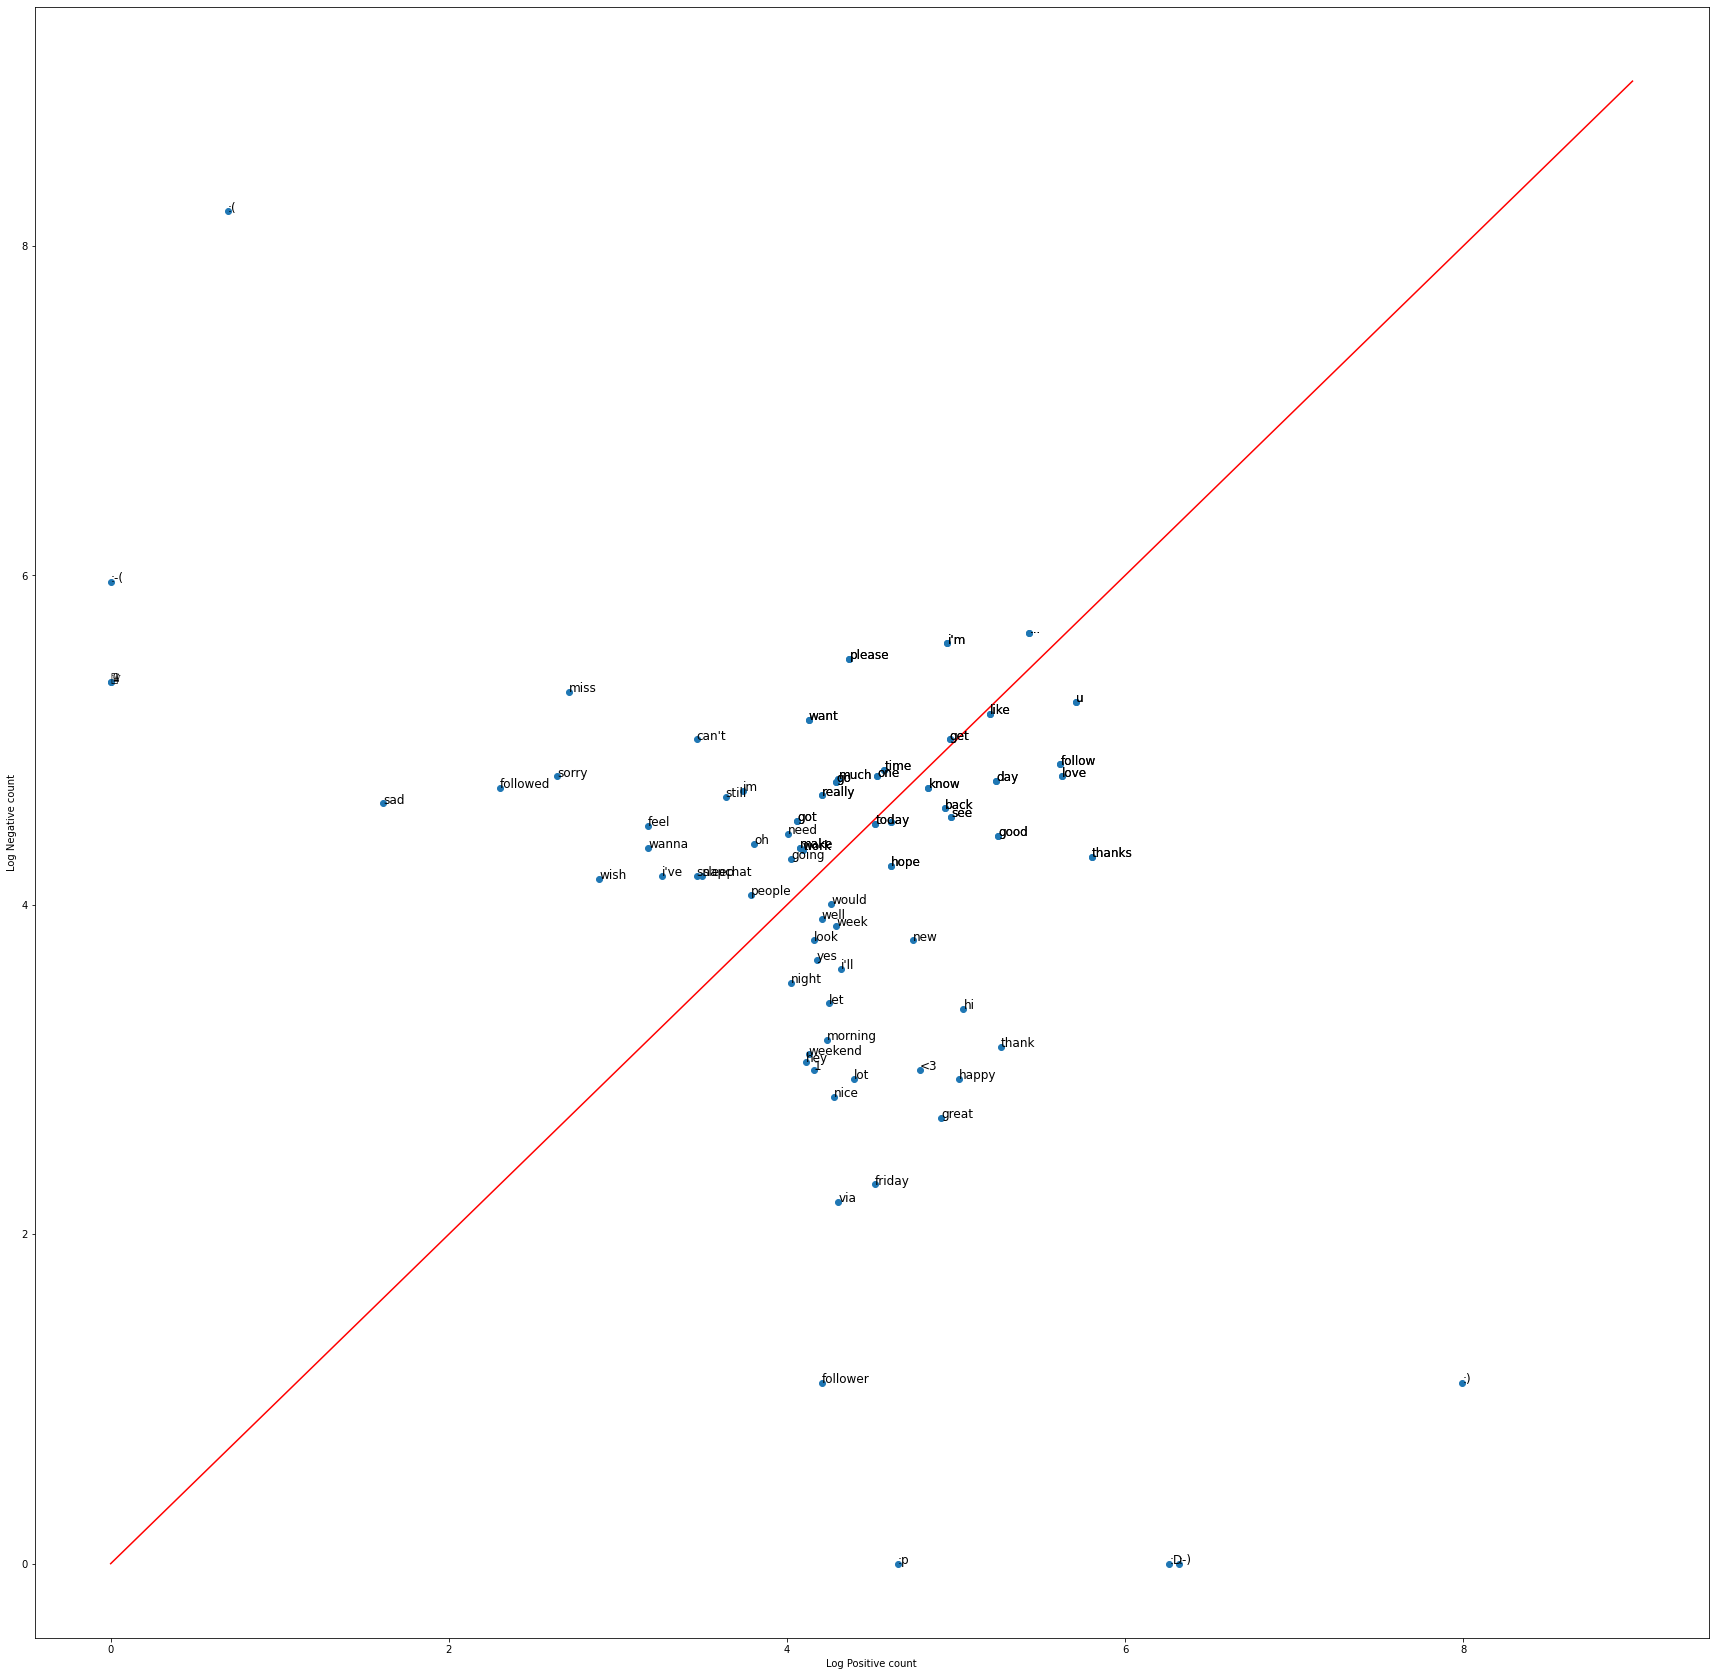

In [ ]:
fig, ax = plt.subplots(figsize = (30, 30))
data = []
for word, _ in list(vocab_dict)[:100]:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in vocab_dict:
        pos = vocab_dict[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in vocab_dict:
        neg = vocab_dict[(word, 0)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

In [ ]:
def extract_freq_feature(tweets:list, vocab:dict):
    """
    Convert tweets to frequency vectors

    tweets: list of tweets (strings)
    vocab: dictionary vocabulary. key: tuple of (token string, sentiment int). value: frequency (int) of the token in the training dats

    returns: numpy array of frequency feature (shape: number of tweets x 3)
    """
    freq_feature = []
    for tweet in tweets:
        tweet = process_tweet(tweet)
        pos = 0
        neg = 0
        # Ignore repeated words
        for word in list(set(tweet)):
            pos += vocab.get((word, 1), 0)
            neg += vocab.get((word, 0), 0)
        # Add 1 for bias
        freq_feature.append([1, pos, neg])
    return np.array(freq_feature)

In [ ]:
X_train = extract_freq_feature(train_tweets, vocab_dict)
X_test = extract_freq_feature(test_tweets, vocab_dict)
X_train, X_train.shape

(array([[   1, 3132,   61],
        [   1, 3503,  414],
        [   1, 3110,  106],
        ...,
        [   1,  131,  747],
        [   1,  129, 3847],
        [   1,  174, 3964]]), (8000, 3))

Text(0, 0.5, 'Negative')

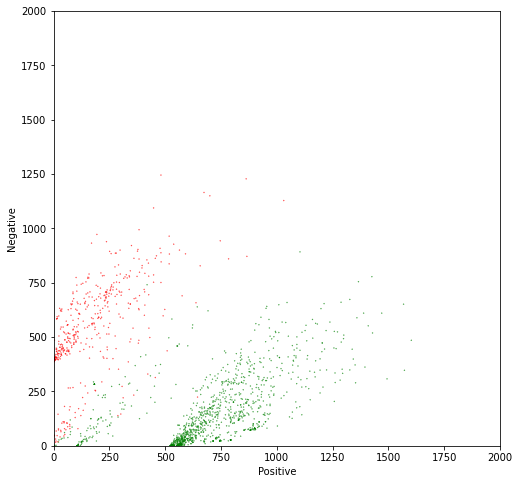

In [ ]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8,8))
plt.ylim(0, 2000)
plt.xlim(0, 2000)

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(X_train[:,1], X_train[:,2], c=[colors[int(k)] for k in Y_train], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Classification

## Logistic regression

In [ ]:
lr_classifier = LogisticRegression(random_state=42).fit(X_train, Y_train)
Y_pred_lr = lr_classifier.predict(X_test)
Y_pred_lr

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
lr_accuracy = lr_classifier.score(X_test, Y_test)
lr_accuracy

0.994

In [ ]:
lr_classifier.classes_

array([0., 1.])

In [ ]:
lr_weights = lr_classifier.coef_
lr_weights

array([[ 0.24478961,  0.00846945, -0.00958943]])

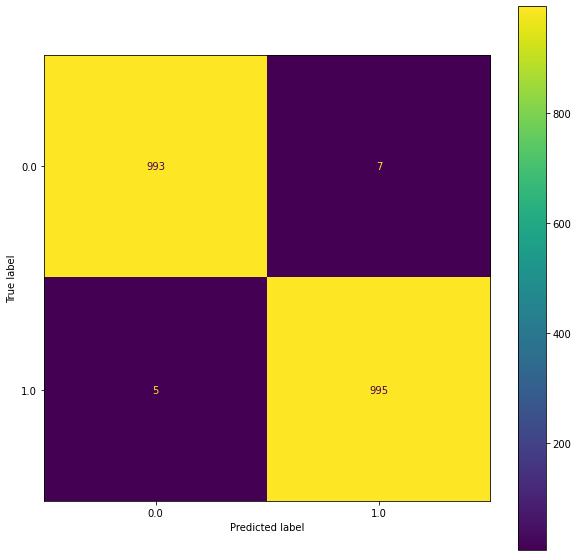

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_lr, ax=ax)
plt.show()

## SVM

In [ ]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, Y_train)
Y_pred_svm = svm_classifier.predict(X_test)
Y_pred_svm

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
svm_accuracy = svm_classifier.score(X_test, Y_test)
svm_accuracy

0.993

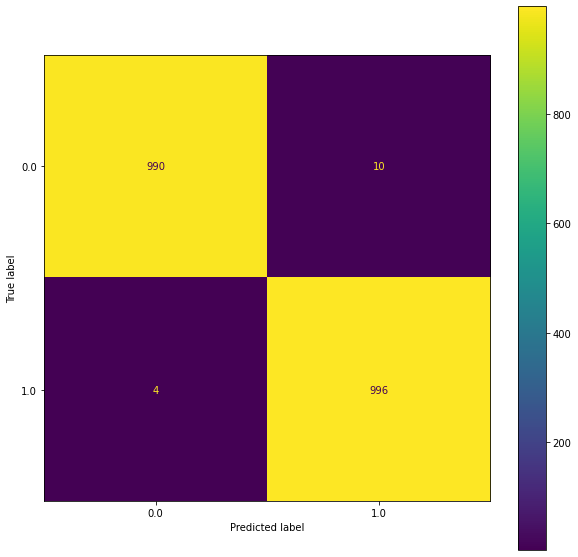

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_svm, ax=ax)
plt.show()

## Naïve Bayes

In [ ]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, Y_train)
Y_pred_nb = nb_classifier.predict(X_test)
Y_pred_nb

array([1., 1., 1., ..., 0., 0., 1.])

In [ ]:
nb_accuracy = nb_classifier.score(X_test, Y_test)
nb_accuracy

0.9705

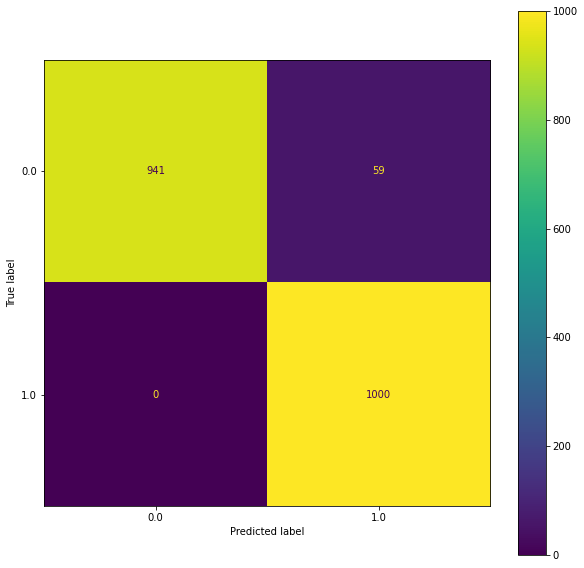

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_nb, ax=ax)
plt.show()